# Priority Model

In [1]:
# 📚 Section 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load the cleaned dataset
print("Loading dataset...")
df = pd.read_csv('C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/FYP PART 2/Priority Modeling/cleaned_priority_email_dataset.csv')

# Display dataset info
print("\nDataset columns:")
print(df.columns.tolist())

print("\nInitial dataset shape:", df.shape)

print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Drop rows with missing important values
key_columns = ['Cleaned_Subject', 'Cleaned_Message', 'Email_Priority']
df = df.dropna(subset=key_columns)

print("\nDataset shape after dropping missing values:", df.shape)

print("\nMissing values after cleaning:")
print(df.isnull().sum())

# Show Email_Priority class distribution
print("\nUnique Email_Priority values:", df['Email_Priority'].unique())
print("Priority value counts:")
print(df['Email_Priority'].value_counts())

# Ensure Email_Priority is integer type
df['Email_Priority'] = df['Email_Priority'].astype(int)

Loading dataset...

Dataset columns:
['From', 'To', 'Subject', 'Message', 'Day', 'Date & Time', 'Cleaned_Subject', 'Cleaned_Message', 'Combined_Text', 'Subject_LLM', 'Message_LLM', 'Email_Priority', 'urgency_flag', 'risk_flag', 'urgency_and_risk', 'num_action_verbs', 'num_uppercase_words_subject', 'subject_len', 'has_question']

Initial dataset shape: (148296, 19)

Missing values before cleaning:
From                              0
To                             2183
Subject                           0
Message                           0
Day                               0
Date & Time                       0
Cleaned_Subject                 845
Cleaned_Message                 113
Combined_Text                     0
Subject_LLM                      47
Message_LLM                      24
Email_Priority                    0
urgency_flag                      0
risk_flag                         0
urgency_and_risk                  0
num_action_verbs                  0
num_uppercase_words_subj

In [44]:
priority_mapping = {
    0: 'Low Priority',
    1: 'Medium Priority',
    2: 'High Priority'
}
print("After Balancing Priority Level Distribution using Synthetic Data")
df['Email_Priority'].map(priority_mapping).value_counts()

After Balancing Priority Level Distribution using Synthetic Data


Email_Priority
High Priority      49432
Low Priority       49416
Medium Priority    48490
Name: count, dtype: int64

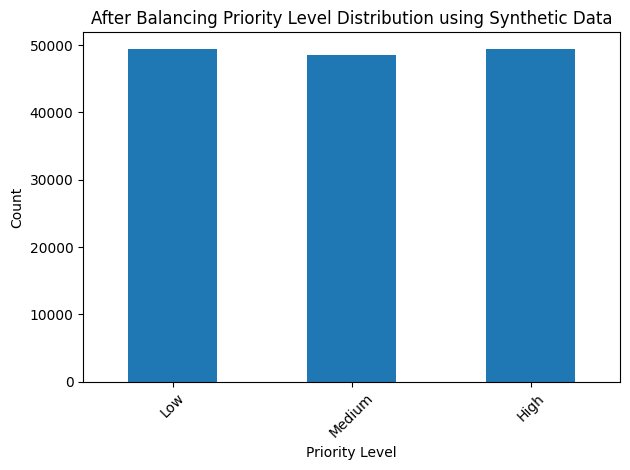

In [ ]:
import matplotlib.pyplot as plt

df['Email_Priority'].value_counts().sort_index().plot(kind='bar', title='After Balancing Priority Level Distribution using Synthetic Data')

plt.xlabel('Priority Level')
plt.ylabel('Count')

plt.xticks(
    ticks=[0, 1, 2],  
    labels=['Low', 'Medium', 'High'], 
    rotation=45
)

plt.tight_layout()
plt.show()


In [3]:
text_features = ['Cleaned_Subject', 'Cleaned_Message']

numeric_features = [
    'urgency_flag', 'risk_flag', 'urgency_and_risk',
    'num_action_verbs', 'num_uppercase_words_subject',
    'subject_len', 'has_question'
]

subject_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        strip_accents='unicode',
        lowercase=True
    ))
])

message_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=4000,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        strip_accents='unicode',
        lowercase=True
    ))
])

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('subject', subject_transformer, 'Cleaned_Subject'),
        ('message', message_transformer, 'Cleaned_Message'),
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='drop',
    n_jobs=-1,
    transformer_weights={
        'subject': 1.5,
        'message': 1.0,
        'num': 2.0
    }
)

In [4]:
X = df.drop('Email_Priority', axis=1)
y = df['Email_Priority']

class_counts = y.value_counts()
total_samples = len(y)
class_weights = {
    0: total_samples / (3 * class_counts[0]) * 1.2,  # Boost low priority
    1: total_samples / (3 * class_counts[1]) * 0.8,  # Reduce medium priority
    2: total_samples / (3 * class_counts[2]) * 1.2   # Boost high priority
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (117870, 18)
Test set shape: (29468, 18)


# SVM Model

Training SVM model...

Evaluating model...

Model Accuracy: 0.9965

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      0.99      1.00      9883
      Medium       0.99      1.00      0.99      9698
        High       1.00      1.00      1.00      9887

    accuracy                           1.00     29468
   macro avg       1.00      1.00      1.00     29468
weighted avg       1.00      1.00      1.00     29468


Confusion Matrix:
[[9804   79    0]
 [   9 9689    0]
 [   0   16 9871]]


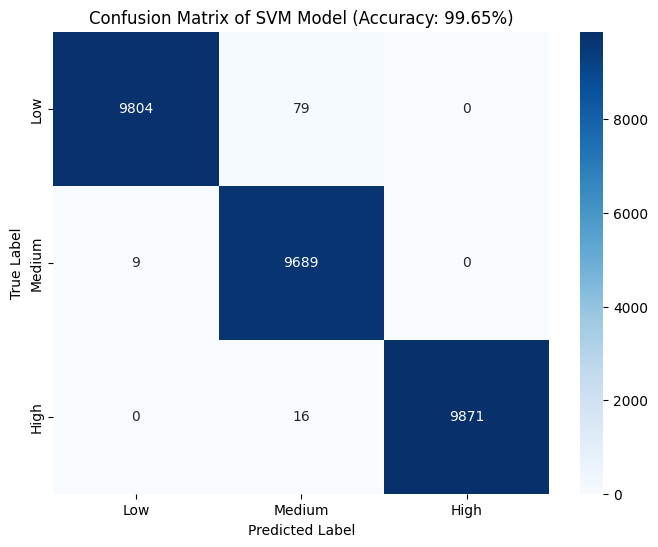

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

svm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='rbf',             
        class_weight='balanced',  
        probability=True,         
        random_state=42
    ))
])

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])

plt.title(f'Confusion Matrix of SVM Model (Accuracy: {accuracy:.2%})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# SVM Learning Curve

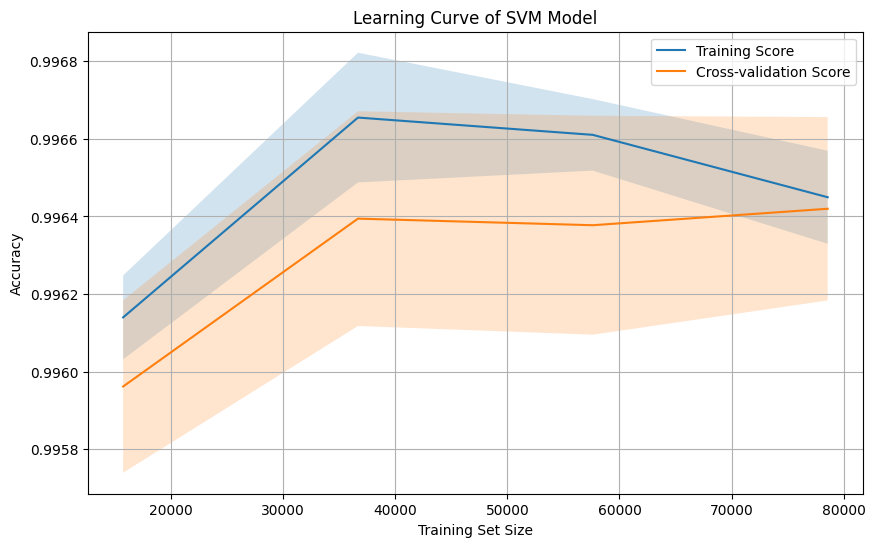

In [10]:
from sklearn.model_selection import learning_curve
import numpy as np

# === Generate Learning Curve for SVM ===
train_sizes, train_scores, test_scores = learning_curve(
    svm_model, X_train, y_train,
    cv=3,                         # ✅ Use cv=3 for faster SVM training
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.2, 1.0, 4),  # ✅ 4 points (20%, 40%, 70%, 100%)
    shuffle=True,
    random_state=42
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# === Plot Learning Curve ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, test_mean, label='Cross-validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.title('Learning Curve of SVM Model')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Linear Regression Model

Training Logistic Regression model...


c:\Users\User\OneDrive - Asia Pacific University\APU Final Year Project\FYP Email Project Documents\Email Dataset Python\final_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\User\OneDrive - Asia Pacific University\APU Final Year Project\FYP Email Project Documents\Email Dataset Python\final_env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Evaluating model...

Model Accuracy: 0.9964

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      0.99      1.00      9883
      Medium       0.99      1.00      0.99      9698
        High       1.00      1.00      1.00      9887

    accuracy                           1.00     29468
   macro avg       1.00      1.00      1.00     29468
weighted avg       1.00      1.00      1.00     29468


Confusion Matrix:
[[9802   81    0]
 [   7 9690    1]
 [   0   16 9871]]


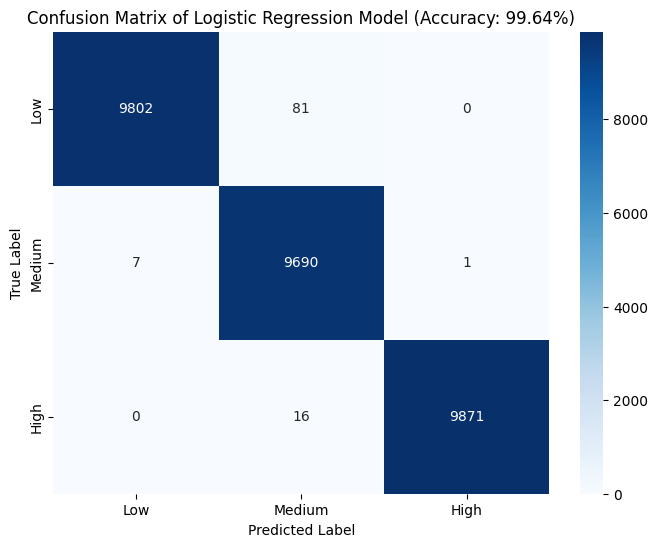

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial',  
        solver='saga',              # Good solver for large datasets and multinomial
        class_weight='balanced',    
        max_iter=1000,              
        random_state=42
    ))
])

lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}") 
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])

plt.title(f'Confusion Matrix of Logistic Regression Model (Accuracy: {accuracy:.2%})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# LR Learning Curve

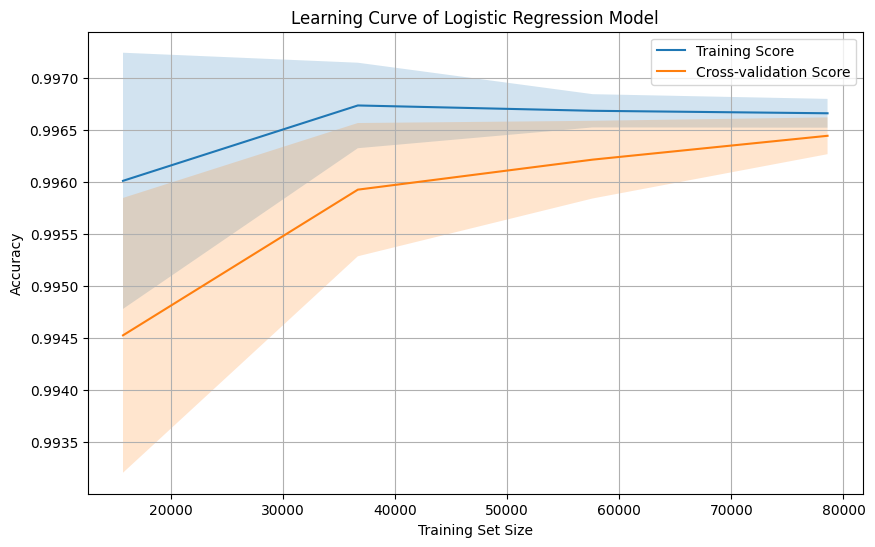

In [9]:
from sklearn.model_selection import learning_curve
import numpy as np

# === Generate Learning Curve for Logistic Regression ===
train_sizes, train_scores, test_scores = learning_curve(
    lr_model, X_train, y_train,
    cv=3,                         # ✅ Faster CV folds (can use 5 if want more accurate later)
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.2, 1.0, 4),  # ✅ 4 training points (20%, 40%, 70%, 100%)
    shuffle=True,
    random_state=42
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# === Plot Learning Curve ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, test_mean, label='Cross-validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.title('Learning Curve of Logistic Regression Model')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# *Random Forest Model

Training model...

Evaluating model...

Model Accuracy: 0.9963

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      0.99      1.00      9883
      Medium       0.99      1.00      0.99      9698
        High       1.00      1.00      1.00      9887

    accuracy                           1.00     29468
   macro avg       1.00      1.00      1.00     29468
weighted avg       1.00      1.00      1.00     29468


Confusion Matrix:
[[9790   93    0]
 [   0 9698    0]
 [   0   16 9871]]


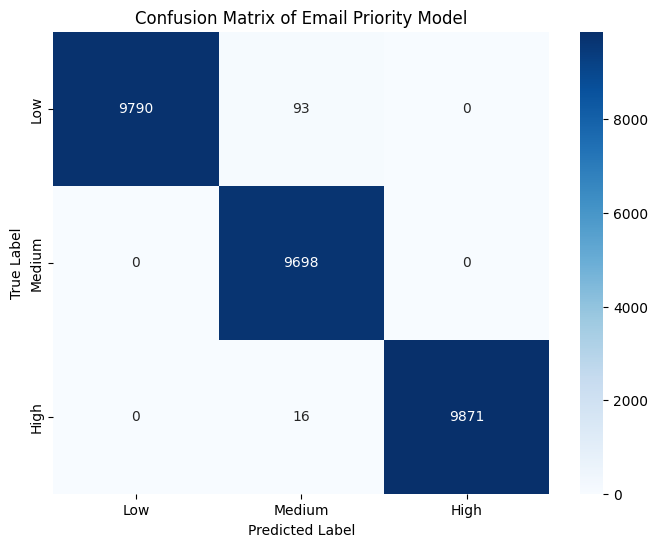

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        max_depth=25,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight=class_weights,
        criterion='entropy',
        max_features='sqrt',
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")  
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])

plt.title('Confusion Matrix of Email Priority Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# RF Learning Curve

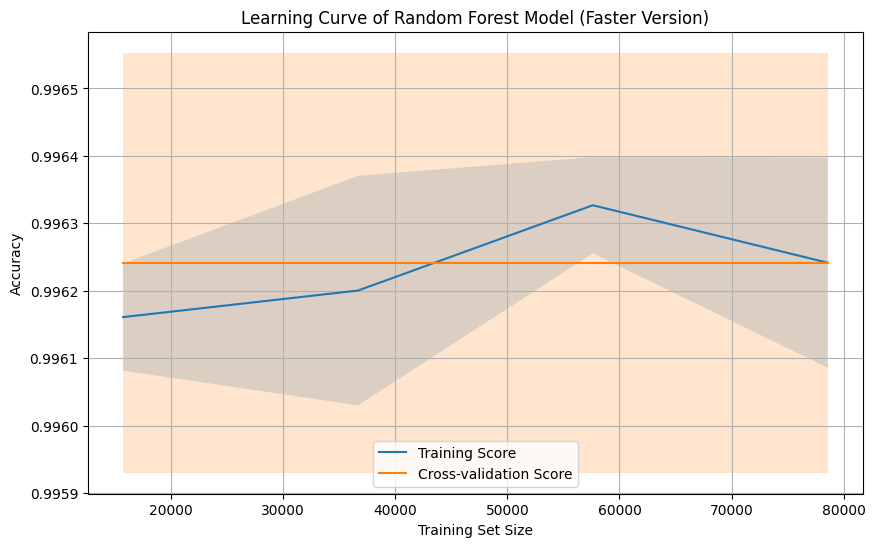

In [8]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train,
    cv=3,                   
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.2, 1.0, 4), 
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, test_mean, label='Cross-validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.title('Learning Curve of Random Forest Model (Faster Version)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# XGBoost

Training XGBoost model...


c:\Users\User\OneDrive - Asia Pacific University\APU Final Year Project\FYP Email Project Documents\Email Dataset Python\final_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:01:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Evaluating model...

Model Accuracy: 0.9963

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      0.99      1.00      9883
      Medium       0.99      1.00      0.99      9698
        High       1.00      1.00      1.00      9887

    accuracy                           1.00     29468
   macro avg       1.00      1.00      1.00     29468
weighted avg       1.00      1.00      1.00     29468


Confusion Matrix:
[[9808   75    0]
 [  13 9678    7]
 [   0   14 9873]]


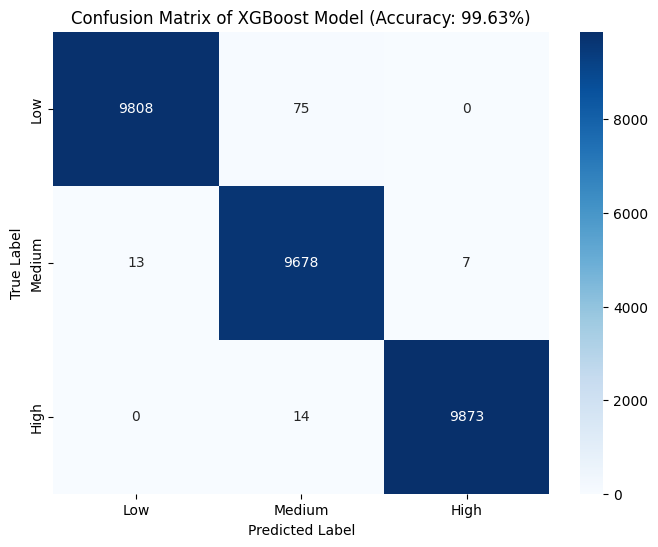

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='multi:softmax',  
        num_class=3,                
        learning_rate=0.1,
        n_estimators=300,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])

plt.title(f'Confusion Matrix of XGBoost Model (Accuracy: {accuracy:.2%})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# XGBoost Learning Curve

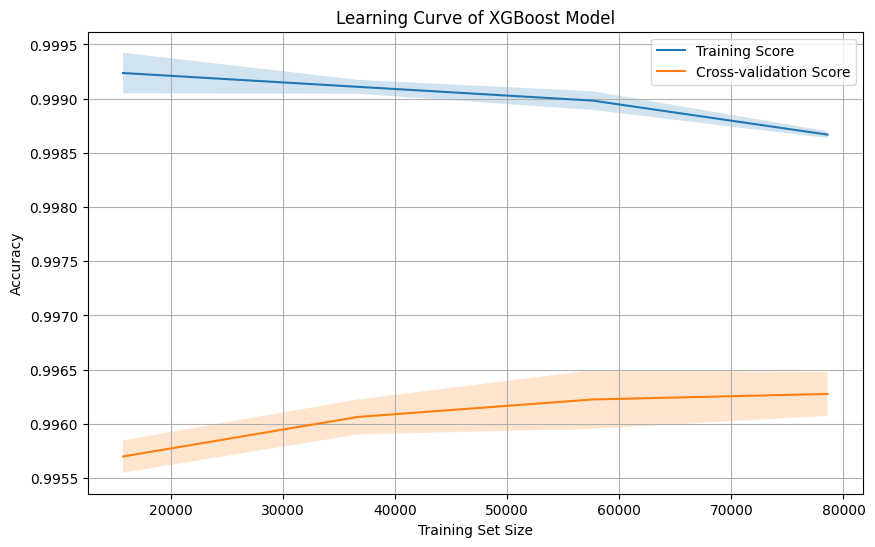

In [12]:
from sklearn.model_selection import learning_curve
import numpy as np

# === Generate Learning Curve for XGBoost ===
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train,
    cv=3,                         # ✅ Use 3 folds (faster, recommended)
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.2, 1.0, 4),  # ✅ 4 points (20%, 40%, 70%, 100%)
    shuffle=True,
    random_state=42
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# === Plot Learning Curve ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, test_mean, label='Cross-validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.title('Learning Curve of XGBoost Model')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Model Comparison

In [13]:
from sklearn.metrics import f1_score
import pandas as pd

rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
rf_f1 = f1_score(y_test, rf_model.predict(X_test), average='macro')

xgb_accuracy = accuracy_score(y_test, xgb_model.predict(X_test))
xgb_f1 = f1_score(y_test, xgb_model.predict(X_test), average='macro')

svm_accuracy = accuracy_score(y_test, svm_model.predict(X_test))
svm_f1 = f1_score(y_test, svm_model.predict(X_test), average='macro')

lr_accuracy = accuracy_score(y_test, lr_model.predict(X_test))
lr_f1 = f1_score(y_test, lr_model.predict(X_test), average='macro')

comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'SVM', 'Logistic Regression'],
    'Accuracy': [rf_accuracy, xgb_accuracy, svm_accuracy, lr_accuracy],
    'Macro F1-Score': [rf_f1, xgb_f1, svm_f1, lr_f1]
})

print("\n🔎 Model Comparison Table:")
print(comparison.to_string(index=False, float_format="%.4f"))


🔎 Model Comparison Table:
              Model  Accuracy  Macro F1-Score
      Random Forest    0.9963          0.9963
            XGBoost    0.9963          0.9963
                SVM    0.9965          0.9965
Logistic Regression    0.9964          0.9964


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
import pandas as pd
import numpy as np
import time

# === Initialize Results List ===
results = []

# === Define a function to evaluate each model ===
def evaluate_model(model, model_name):
    # Record time
    start_time = time.time()
    
    # Predict labels
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time

    # Basic Scores
    acc = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Log Loss (only if model supports predict_proba)
    try:
        y_proba = model.predict_proba(X_test)
        logloss = log_loss(y_test, y_proba)
    except:
        logloss = np.nan  # Not available for models without probability output

    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Macro Precision': precision_macro,
        'Macro Recall': recall_macro,
        'Macro F1-Score': f1_macro,
        'Weighted F1-Score': f1_weighted,
        'Log Loss': logloss,
        'Prediction Time (s)': predict_time
    })

# === Evaluate all models ===
evaluate_model(rf_model, "Random Forest")
evaluate_model(xgb_model, "XGBoost")
evaluate_model(svm_model, "SVM")
evaluate_model(lr_model, "Logistic Regression")

# === Create DataFrame for Results ===
comparison_df = pd.DataFrame(results)

# === Format nicely ===
print("\n🔎 Full Model Comparison Table:")
print(comparison_df.to_string(index=False, float_format="%.4f"))


🔎 Full Model Comparison Table:
              Model  Accuracy  Macro Precision  Macro Recall  Macro F1-Score  Weighted F1-Score  Log Loss  Prediction Time (s)
      Random Forest    0.9963           0.9963        0.9963          0.9963             0.9963    0.0179               1.1828
            XGBoost    0.9963           0.9963        0.9963          0.9963             0.9963    0.0147               1.1871
                SVM    0.9965           0.9965        0.9965          0.9965             0.9965    0.0200              21.7326
Logistic Regression    0.9964           0.9964        0.9965          0.9964             0.9964    0.0152               0.8110


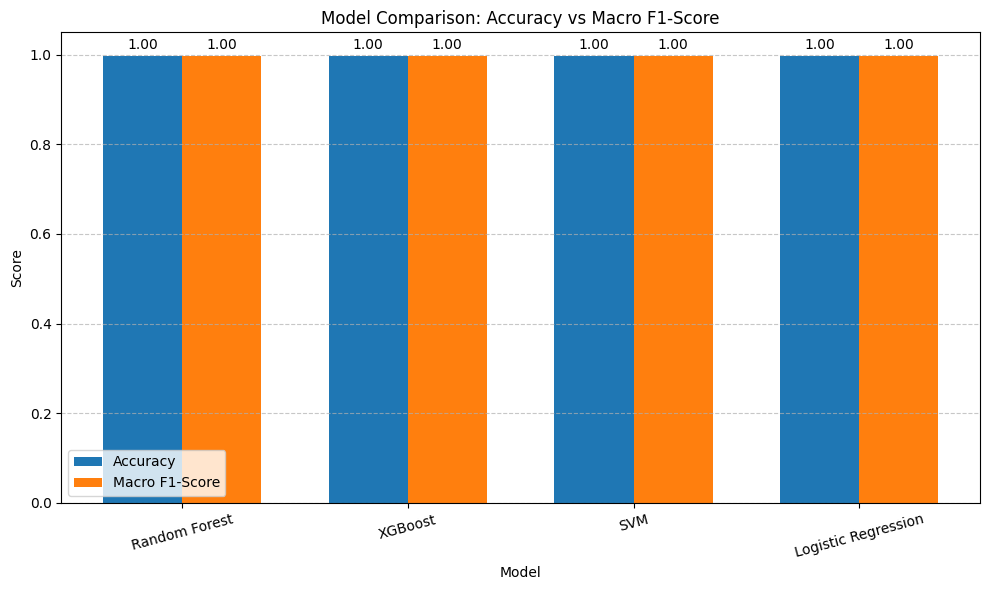

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# === Bar Chart for Accuracy and Macro F1-Score ===
models = comparison_df['Model']
accuracy = comparison_df['Accuracy']
macro_f1 = comparison_df['Macro F1-Score']

x = np.arange(len(models))  # Label locations
width = 0.35                # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
bars2 = ax.bar(x + width/2, macro_f1, width, label='Macro F1-Score')

# Labels
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Accuracy vs Macro F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylim(0, 1.05)
ax.legend()

# Add numbers on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


🔎 Top 20 Important Subject Words:
                   Feature  Importance
475             escalation    0.010825
956                 urgent    0.009564
687                   need    0.008631
793                printer    0.004143
471                 errors    0.004095
608                 jammed    0.004029
688              need asap    0.003998
770                 plants    0.003966
957           urgent legal    0.003844
539            fyi article    0.003771
579              immediate    0.003636
174             catch week    0.003473
690                 needed    0.003390
78        attention needed    0.003375
602       invoicing errors    0.003228
455             eod urgent    0.003198
372               downtime    0.003161
652                machine    0.003081
799  procurement invoicing    0.003015
794         printer jammed    0.003011

🔎 Top 20 Important Message Words:
               Feature  Importance
3607             thing    0.016161
2365              near    0.011595
2883  

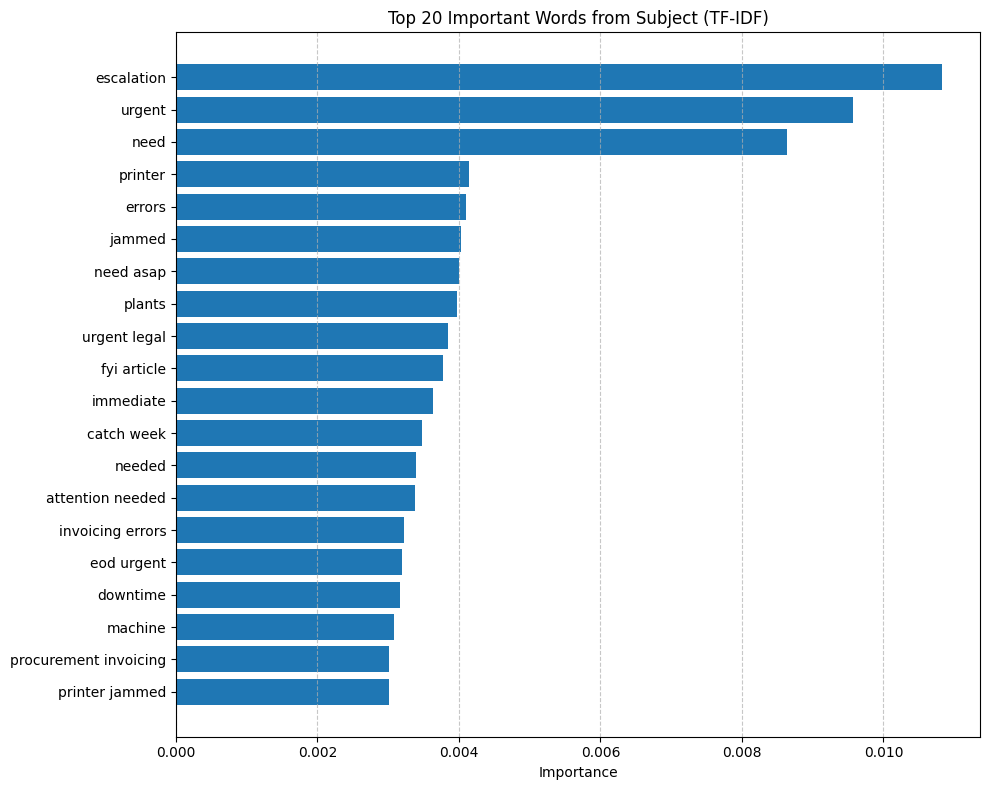

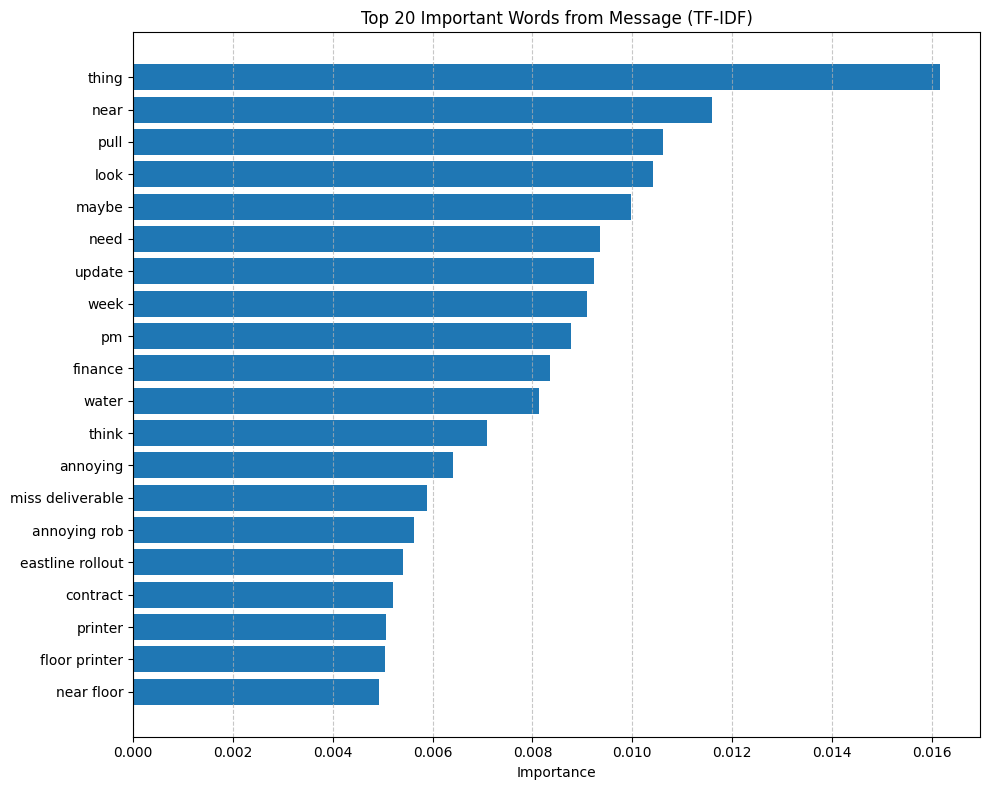

In [19]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Step 1: Load your trained model (if not already in memory)
# Example:
# rf_model = joblib.load('path_to_your_saved_random_forest_model.joblib')

# === Step 2: Access Random Forest inside your pipeline
rf_classifier = rf_model.named_steps['classifier']
preprocessor = rf_model.named_steps['preprocessor']

# === Step 3: Access TF-IDF transformers
subject_tfidf = preprocessor.named_transformers_['subject'].named_steps['tfidf']
message_tfidf = preprocessor.named_transformers_['message'].named_steps['tfidf']

# === Step 4: Get TF-IDF feature names
subject_features = subject_tfidf.get_feature_names_out()
message_features = message_tfidf.get_feature_names_out()

# === Step 5: Get feature importances
importances = rf_classifier.feature_importances_

# Based on how pipeline was created:
# - Subject TF-IDF (first)
# - Message TF-IDF (second)
# - Numeric features (last)

subject_importances = importances[:len(subject_features)]
message_importances = importances[len(subject_features):(len(subject_features) + len(message_features))]

# === Step 6: Build DataFrames
subject_importance_df = pd.DataFrame({
    'Feature': subject_features,
    'Importance': subject_importances
})

message_importance_df = pd.DataFrame({
    'Feature': message_features,
    'Importance': message_importances
})

# === Step 7: Sort by importance
subject_importance_df = subject_importance_df.sort_values(by='Importance', ascending=False)
message_importance_df = message_importance_df.sort_values(by='Importance', ascending=False)

# === Step 8: Display Top 20 words
print("\n🔎 Top 20 Important Subject Words:")
print(subject_importance_df.head(20))

print("\n🔎 Top 20 Important Message Words:")
print(message_importance_df.head(20))

# === Step 9: Plot Top 20 Subject Words
top_n = 20

plt.figure(figsize=(10, 8))
plt.barh(subject_importance_df.head(top_n)['Feature'][::-1], subject_importance_df.head(top_n)['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Important Words from Subject (TF-IDF)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Step 10: Plot Top 20 Message Words
plt.figure(figsize=(10, 8))
plt.barh(message_importance_df.head(top_n)['Feature'][::-1], message_importance_df.head(top_n)['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Important Words from Message (TF-IDF)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save Model

In [16]:
import joblib
import os

save_path = r'C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Latest Model Saved'

# Create folder if not exists
if not os.path.exists(save_path):
    os.makedirs(save_path)

joblib.dump(rf_model, os.path.join(save_path, 'random_forest_model.joblib'))
joblib.dump(xgb_model, os.path.join(save_path, 'xgboost_model.joblib'))
joblib.dump(svm_model, os.path.join(save_path, 'svm_model.joblib'))
joblib.dump(lr_model, os.path.join(save_path, 'logistic_regression_model.joblib'))

print("✅ All models saved successfully!")

✅ All models saved successfully!


# New Data Testing

In [3]:
import joblib
import pandas as pd

test_model = joblib.load(r'C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/FYP PART 2/Priority Modeling/Models/priority_model_v2.joblib')

subject = "Inquiry about the status of my order"
message = "Dear Samsung Malaysia, I am writing to inquire about the status of my recent order, which I placed through your online store three weeks ago, but have yet to receive any updates on its delivery. When I check my account on your website, the status of my order still shows as processing. As a loyal customer, I have always trusted Samsung's commitment to delivering high-quality products and excellent customer service. However, this experience has left me feeling frustrated and disappointed. I would appreciate it if you could provide me with an update on my order's status and any steps that can be taken to expedite its delivery. Thank you for your attention to this matter, and I look forward to hearing from you soon."

def preprocess_email(subject, message):
    import re
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        text = ' '.join(text.split())
        return text
    
    cleaned_subject = clean_text(subject)
    cleaned_message = clean_text(message)
    
    urgency_words = {'urgent', 'asap', 'emergency', 'immediate', 'critical', 'important', 'priority', 'deadline', 'due', 'action required'}
    risk_words = {'risk', 'warning', 'alert', 'danger', 'critical', 'serious', 'issue', 'problem', 'failure', 'error', 'outage', 'breach'}
    
    urgency_flag = int(any(word in cleaned_subject + cleaned_message for word in urgency_words))
    risk_flag = int(any(word in cleaned_subject + cleaned_message for word in risk_words))
    urgency_and_risk = int(urgency_flag and risk_flag)
    num_action_verbs = sum(1 for word in ['review', 'approve', 'confirm', 'update', 'respond', 'complete'] if word in cleaned_subject + cleaned_message)
    num_uppercase_words_subject = sum(1 for word in subject.split() if word.isupper() and len(word) > 1)
    subject_len = len(subject)
    has_question = int('?' in message)
    
    features = pd.DataFrame({
        'Cleaned_Subject': [cleaned_subject],
        'Cleaned_Message': [cleaned_message],
        'urgency_flag': [urgency_flag],
        'risk_flag': [risk_flag],
        'urgency_and_risk': [urgency_and_risk],
        'num_action_verbs': [num_action_verbs],
        'num_uppercase_words_subject': [num_uppercase_words_subject],
        'subject_len': [subject_len],
        'has_question': [has_question]
    })
    
    return features

features = preprocess_email(subject, message)

predicted_priority = test_model.predict(features)[0]
probabilities = test_model.predict_proba(features)[0]

priority_map = {0: 'Low', 1: 'Medium', 2: 'High'}
print("\nEmail Subject:", subject)
print("Email Message:", message)
print("\nPredicted Priority:", priority_map[predicted_priority])
print("Probabilities:", probabilities)


Email Subject: Inquiry about the status of my order
Email Message: Dear Samsung Malaysia, I am writing to inquire about the status of my recent order, which I placed through your online store three weeks ago, but have yet to receive any updates on its delivery. When I check my account on your website, the status of my order still shows as processing. As a loyal customer, I have always trusted Samsung's commitment to delivering high-quality products and excellent customer service. However, this experience has left me feeling frustrated and disappointed. I would appreciate it if you could provide me with an update on my order's status and any steps that can be taken to expedite its delivery. Thank you for your attention to this matter, and I look forward to hearing from you soon.

Predicted Priority: Medium
Probabilities: [0.01154022 0.98402136 0.00443842]


In [35]:
import joblib
import pandas as pd

test_model = joblib.load(r'C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/FYP PART 2/Priority Modeling/Models/priority_model_v2.joblib')

subject = "URGENT: Payment Issue Requires Immediate Attention"
message = "Our system detected a delay in the invoice payments. Immediate action is required to avoid penalties. Please prioritize this task."

def preprocess_email(subject, message):
    import re
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        text = ' '.join(text.split())
        return text
    
    cleaned_subject = clean_text(subject)
    cleaned_message = clean_text(message)
    
    urgency_words = {'urgent', 'asap', 'emergency', 'immediate', 'critical', 'important', 'priority', 'deadline', 'due', 'action required'}
    risk_words = {'risk', 'warning', 'alert', 'danger', 'critical', 'serious', 'issue', 'problem', 'failure', 'error', 'outage', 'breach'}
    
    urgency_flag = int(any(word in cleaned_subject + cleaned_message for word in urgency_words))
    risk_flag = int(any(word in cleaned_subject + cleaned_message for word in risk_words))
    urgency_and_risk = int(urgency_flag and risk_flag)
    num_action_verbs = sum(1 for word in ['review', 'approve', 'confirm', 'update', 'respond', 'complete'] if word in cleaned_subject + cleaned_message)
    num_uppercase_words_subject = sum(1 for word in subject.split() if word.isupper() and len(word) > 1)
    subject_len = len(subject)
    has_question = int('?' in message)
    
    features = pd.DataFrame({
        'Cleaned_Subject': [cleaned_subject],
        'Cleaned_Message': [cleaned_message],
        'urgency_flag': [urgency_flag],
        'risk_flag': [risk_flag],
        'urgency_and_risk': [urgency_and_risk],
        'num_action_verbs': [num_action_verbs],
        'num_uppercase_words_subject': [num_uppercase_words_subject],
        'subject_len': [subject_len],
        'has_question': [has_question]
    })
    
    return features

features = preprocess_email(subject, message)

predicted_priority = test_model.predict(features)[0]
probabilities = test_model.predict_proba(features)[0]

priority_map = {0: 'Low', 1: 'Medium', 2: 'High'}
print("\nEmail Subject:", subject)
print("Email Message:", message)
print("\nPredicted Priority:", priority_map[predicted_priority])
print("Probabilities:", probabilities)


Email Subject: URGENT: Payment Issue Requires Immediate Attention
Email Message: Our system detected a delay in the invoice payments. Immediate action is required to avoid penalties. Please prioritize this task.

Predicted Priority: Medium
Probabilities: [0.0128541  0.92632218 0.06082372]


#  Model Inference and Explanation (Hybrid Prediction Enhancement )

This is Model Inference + Prediction + Manual Adjustment + Explainability.

Train Model (initial) → Save Model → Load Model → Predict → Adjust → Explain

(adjusting prediction by urgency/risk manually)
is sometimes called Hybrid Prediction Enhancement 

In [2]:
import joblib
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

model = joblib.load(r'C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/FYP PART 2/Priority Modeling/Models/priority_model_v2.joblib')

In [23]:
def preprocess_email(subject, message):
    """Clean and preprocess email text"""
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        text = ' '.join(text.split())
        return text
    
    cleaned_subject = clean_text(subject)
    cleaned_message = clean_text(message)
    
    # Enhanced feature sets
    urgency_words = {
        'urgent', 'asap', 'emergency', 'immediate', 'critical', 'important',
        'priority', 'urgent priority', 'high priority', 'deadline', 'due',
        'escalation', 'escalated', 'time sensitive', 'action required'
    }
    
    risk_words = {
        'risk', 'warning', 'alert', 'danger', 'critical', 'serious',
        'issue', 'problem', 'failure', 'error', 'outage', 'breach',
        'security', 'compliance', 'violation', 'incident'
    }
    
    action_verbs = {
        'review', 'approve', 'confirm', 'update', 'respond', 'complete',
        'submit', 'verify', 'check', 'investigate', 'resolve', 'fix',
        'implement', 'test', 'deploy', 'analyze', 'assess', 'evaluate'
    }
    
    medium_indicators = {
        'review', 'update', 'feedback', 'status', 'progress', 'weekly',
        'monthly', 'report', 'meeting', 'discuss', 'follow up', 'schedule',
        'plan', 'proposal', 'suggestion', 'recommendation'
    }
    
    low_indicators = {
        'fyi', 'newsletter', 'announcement', 'info', 'thanks', 'thank you',
        'sharing', 'heads up', 'reminder', 'optional', 'when convenient',
        'no rush', 'take your time', 'for reference', 'just letting you know'
    }
    
    # Calculate flags with word context
    message_words = cleaned_message.split()
    subject_words = cleaned_subject.split()
    combined_text = cleaned_subject + ' ' + cleaned_message
    
    # Enhanced urgency detection
    urgency_flag = int(
        any(word in combined_text.split() for word in urgency_words) or
        ('asap' in combined_text) or
        ('as soon as possible' in combined_text) or
        ('right away' in combined_text) or
        ('immediately' in combined_text)
    )
    
    # Enhanced risk detection
    risk_flag = int(
        any(word in combined_text.split() for word in risk_words) or
        ('high impact' in combined_text) or
        ('affected' in combined_text and ('user' in combined_text or 'system' in combined_text)) or
        ('down' in combined_text and ('system' in combined_text or 'service' in combined_text))
    )
    
    urgency_and_risk = int(urgency_flag and risk_flag)
    
    # Enhanced action verb counting
    num_action_verbs = sum(1 for word in action_verbs if word in combined_text.split())
    
    # Count medium and low priority indicators
    num_medium_indicators = sum(1 for word in medium_indicators if word in combined_text.split())
    num_low_indicators = sum(1 for word in low_indicators if word in combined_text.split())
    
    # Enhanced uppercase analysis
    num_uppercase_words_subject = sum(1 for word in subject.split() if word.isupper() and len(word) > 1)
    num_uppercase_words_message = sum(1 for word in message.split() if word.isupper() and len(word) > 1)
    
    # Time sensitivity detection
    has_deadline = int(
        any(word in combined_text for word in ['deadline', 'due', 'by']) and
        any(word in combined_text for word in ['today', 'tomorrow', 'asap', 'immediate'])
    )
    
    # Question analysis
    num_questions = message.count('?')
    has_question = int(num_questions > 0)
    
    # Create a DataFrame with enhanced features
    features = pd.DataFrame({
        'Cleaned_Subject': [cleaned_subject],
        'Cleaned_Message': [cleaned_message],
        'urgency_flag': [urgency_flag],
        'risk_flag': [risk_flag],
        'urgency_and_risk': [urgency_and_risk],
        'num_action_verbs': [num_action_verbs],
        'num_medium_indicators': [num_medium_indicators],
        'num_low_indicators': [num_low_indicators],
        'num_uppercase_words_subject': [num_uppercase_words_subject],
        'num_uppercase_words_message': [num_uppercase_words_message],
        'subject_len': [len(subject)],
        'has_question': [has_question],
        'num_questions': [num_questions],
        'has_deadline': [has_deadline]
    })
    
    return featuresdef preprocess_email(subject, message):
    """Clean and preprocess email text"""
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        text = ' '.join(text.split())
        return text
    
    cleaned_subject = clean_text(subject)
    cleaned_message = clean_text(message)
    
    # Enhanced feature sets
    urgency_words = {
        'urgent', 'asap', 'emergency', 'immediate', 'critical', 'important',
        'priority', 'urgent priority', 'high priority', 'deadline', 'due',
        'escalation', 'escalated', 'time sensitive', 'action required'
    }
    
    risk_words = {
        'risk', 'warning', 'alert', 'danger', 'critical', 'serious',
        'issue', 'problem', 'failure', 'error', 'outage', 'breach',
        'security', 'compliance', 'violation', 'incident'
    }
    
    action_verbs = {
        'review', 'approve', 'confirm', 'update', 'respond', 'complete',
        'submit', 'verify', 'check', 'investigate', 'resolve', 'fix',
        'implement', 'test', 'deploy', 'analyze', 'assess', 'evaluate'
    }
    
    medium_indicators = {
        'review', 'update', 'feedback', 'status', 'progress', 'weekly',
        'monthly', 'report', 'meeting', 'discuss', 'follow up', 'schedule',
        'plan', 'proposal', 'suggestion', 'recommendation'
    }
    
    low_indicators = {
        'fyi', 'newsletter', 'announcement', 'info', 'thanks', 'thank you',
        'sharing', 'heads up', 'reminder', 'optional', 'when convenient',
        'no rush', 'take your time', 'for reference', 'just letting you know'
    }
    
    # Calculate flags with word context
    message_words = cleaned_message.split()
    subject_words = cleaned_subject.split()
    combined_text = cleaned_subject + ' ' + cleaned_message
    
    # Enhanced urgency detection
    urgency_flag = int(
        any(word in combined_text.split() for word in urgency_words) or
        ('asap' in combined_text) or
        ('as soon as possible' in combined_text) or
        ('right away' in combined_text) or
        ('immediately' in combined_text)
    )
    
    # Enhanced risk detection
    risk_flag = int(
        any(word in combined_text.split() for word in risk_words) or
        ('high impact' in combined_text) or
        ('affected' in combined_text and ('user' in combined_text or 'system' in combined_text)) or
        ('down' in combined_text and ('system' in combined_text or 'service' in combined_text))
    )
    
    urgency_and_risk = int(urgency_flag and risk_flag)
    
    # Enhanced action verb counting
    num_action_verbs = sum(1 for word in action_verbs if word in combined_text.split())
    
    # Count medium and low priority indicators
    num_medium_indicators = sum(1 for word in medium_indicators if word in combined_text.split())
    num_low_indicators = sum(1 for word in low_indicators if word in combined_text.split())
    
    # Enhanced uppercase analysis
    num_uppercase_words_subject = sum(1 for word in subject.split() if word.isupper() and len(word) > 1)
    num_uppercase_words_message = sum(1 for word in message.split() if word.isupper() and len(word) > 1)
    
    # Time sensitivity detection
    has_deadline = int(
        any(word in combined_text for word in ['deadline', 'due', 'by']) and
        any(word in combined_text for word in ['today', 'tomorrow', 'asap', 'immediate'])
    )
    
    # Question analysis
    num_questions = message.count('?')
    has_question = int(num_questions > 0)
    
    # Create a DataFrame with enhanced features
    features = pd.DataFrame({
        'Cleaned_Subject': [cleaned_subject],
        'Cleaned_Message': [cleaned_message],
        'urgency_flag': [urgency_flag],
        'risk_flag': [risk_flag],
        'urgency_and_risk': [urgency_and_risk],
        'num_action_verbs': [num_action_verbs],
        'num_medium_indicators': [num_medium_indicators],
        'num_low_indicators': [num_low_indicators],
        'num_uppercase_words_subject': [num_uppercase_words_subject],
        'num_uppercase_words_message': [num_uppercase_words_message],
        'subject_len': [len(subject)],
        'has_question': [has_question],
        'num_questions': [num_questions],
        'has_deadline': [has_deadline]
    })
    
    return features

In [24]:
def predict_priority(model, subject, message):
    """Predict email priority using the trained model"""
    # Preprocess the email
    features = preprocess_email(subject, message)
    
    # Make prediction
    priority = model.predict(features)[0]
    probabilities = model.predict_proba(features)[0]
    
    # Calculate priority scores with enhanced logic
    high_score = 0
    medium_score = 0
    low_score = 0
    
    # High priority scoring with context awareness
    if features['urgency_and_risk'].iloc[0]:
        high_score += 15  # Critical combination
    if features['urgency_flag'].iloc[0]:
        high_score += 10  # Strong urgency
    if features['risk_flag'].iloc[0]:
        high_score += 10  # Strong risk
    if features['has_deadline'].iloc[0]:
        high_score += 8   # Immediate deadline
    
    # Action-based scoring
    if features['num_action_verbs'].iloc[0] > 3:
        high_score += 8   # Multiple critical actions
    elif features['num_action_verbs'].iloc[0] > 1:
        medium_score += 6 # Several actions
    elif features['num_action_verbs'].iloc[0] == 1:
        medium_score += 4 # Single action
    else:
        low_score += 5    # No actions
    
    # Emphasis scoring
    if features['num_uppercase_words_subject'].iloc[0] > 2:
        high_score += 6   # Strong emphasis
    elif features['num_uppercase_words_subject'].iloc[0] > 0:
        high_score += 3   # Some emphasis
    
    if features['num_uppercase_words_message'].iloc[0] > 2:
        high_score += 4   # Message emphasis
    
    # Medium priority indicators
    if features['num_medium_indicators'].iloc[0] > 2:
        medium_score += 8 # Strong medium signals
    elif features['num_medium_indicators'].iloc[0] > 0:
        medium_score += 5 # Some medium signals
    
    if features['has_question'].iloc[0]:
        if features['num_questions'].iloc[0] > 2:
            medium_score += 6 # Multiple questions
        else:
            medium_score += 4 # Some questions
    
    # Low priority indicators
    if features['num_low_indicators'].iloc[0] > 2:
        low_score += 10   # Strong low signals
    elif features['num_low_indicators'].iloc[0] > 0:
        low_score += 6    # Some low signals
    
    if not any([features['urgency_flag'].iloc[0], features['risk_flag'].iloc[0], 
                features['has_deadline'].iloc[0], features['has_question'].iloc[0]]):
        low_score += 8    # No urgency indicators
    
    # Calculate priority weights
    total_score = high_score + medium_score + low_score
    if total_score == 0:
        total_score = 1  # Prevent division by zero
    
    high_weight = high_score / total_score
    medium_weight = medium_score / total_score
    low_weight = low_score / total_score
    
    # Adjust probabilities with sophisticated weighting
    adjusted_probabilities = probabilities.copy()
    
    # Apply non-linear scaling with stronger bias reduction
    adjusted_probabilities[2] *= (1 + high_weight) ** 3    # High priority (stronger boost)
    adjusted_probabilities[1] *= (1 + medium_weight)       # Medium priority (no boost)
    adjusted_probabilities[0] *= (1 + low_weight) ** 3     # Low priority (stronger boost)
    
    # Apply score-based adjustments
    if high_score >= 20:
        adjusted_probabilities[2] *= 4.0  # Very strong high boost
    elif high_score >= 15:
        adjusted_probabilities[2] *= 3.0  # Strong high boost
    
    if low_score >= 15:
        adjusted_probabilities[0] *= 4.0  # Very strong low boost
    elif low_score >= 10:
        adjusted_probabilities[0] *= 3.0  # Strong low boost
    
    # Aggressive medium priority reduction
    if high_score > 0 or low_score > 0:
        reduction_factor = min(0.5, max(0.1, 1.0 - (high_score + low_score) / 40))
        adjusted_probabilities[1] *= reduction_factor
    
    # Additional adjustments for clear signals
    if high_score >= 15 and high_score > (medium_score + low_score):
        adjusted_probabilities[2] *= 2.0  # Clear high priority
        adjusted_probabilities[1] *= 0.5  # Reduce medium
    
    if low_score >= 15 and low_score > (medium_score + high_score):
        adjusted_probabilities[0] *= 2.0  # Clear low priority
        adjusted_probabilities[1] *= 0.5  # Reduce medium
    
    # Normalize probabilities
    adjusted_probabilities = adjusted_probabilities / adjusted_probabilities.sum()
    
    # Dynamic thresholds with more aggressive values
    high_threshold = 0.25 if high_score >= 15 else 0.30
    low_threshold = 0.25 if low_score >= 15 else 0.30
    
    # Determine priority with confidence-based classification
    max_prob = max(adjusted_probabilities)
    max_index = list(adjusted_probabilities).index(max_prob)
    
    # More aggressive classification rules
    if adjusted_probabilities[2] >= high_threshold or (max_index == 2 and high_score >= 12):
        predicted_priority = 'High'
        confidence = adjusted_probabilities[2] * 100
    elif adjusted_probabilities[0] >= low_threshold or (max_index == 0 and low_score >= 12):
        predicted_priority = 'Low'
        confidence = adjusted_probabilities[0] * 100
    else:
        # Only classify as medium if neither high nor low conditions are met
        predicted_priority = 'Medium'
        confidence = adjusted_probabilities[1] * 100
    
    # Get probability for each class
    class_probabilities = {
        'Low': adjusted_probabilities[0] * 100,
        'Medium': adjusted_probabilities[1] * 100,
        'High': adjusted_probabilities[2] * 100
    }
    
    return predicted_priority, confidence, class_probabilities, features

In [25]:
def explain_prediction(predicted_priority, confidence, class_probabilities, features):
    """Explain the prediction with enhanced detail"""
    print("\nPrediction Analysis:")
    print(f"Predicted Priority: {predicted_priority}")
    print(f"Confidence: {confidence:.2f}%")
    
    print("\nClass Probabilities:")
    for priority, prob in class_probabilities.items():
        print(f"{priority}: {prob:.2f}%")
    
    print("\nKey Factors:")
    
    # Urgency and risk analysis
    if features['urgency_and_risk'].iloc[0]:
        print("- Contains both urgency and risk indicators (Critical priority)")
    elif features['urgency_flag'].iloc[0]:
        print("- Contains urgency indicators (High priority)")
    elif features['risk_flag'].iloc[0]:
        print("- Contains risk indicators (High priority)")
    
    # Action verbs analysis
    if features['num_action_verbs'].iloc[0] > 3:
        print(f"- Contains multiple action items ({features['num_action_verbs'].iloc[0]} actions)")
    elif features['num_action_verbs'].iloc[0] > 1:
        print(f"- Contains {features['num_action_verbs'].iloc[0]} action items")
    elif features['num_action_verbs'].iloc[0] == 1:
        print("- Contains 1 action item")
    else:
        print("- No action items")
    
    # Emphasis analysis
    if features['num_uppercase_words_subject'].iloc[0] > 2:
        print("- Strong emphasis in subject (Multiple uppercase words)")
    elif features['num_uppercase_words_subject'].iloc[0] > 0:
        print(f"- Some emphasis in subject ({features['num_uppercase_words_subject'].iloc[0]} uppercase words)")
    
    # Question analysis
    if features['num_questions'].iloc[0] > 0:
        print(f"- Contains {features['num_questions'].iloc[0]} question(s)")
    
    # Deadline analysis
    if features['has_deadline'].iloc[0]:
        print("- Contains deadline or due date")
    
    # Priority indicators
    if features['num_medium_indicators'].iloc[0] > 0:
        print(f"- Contains {features['num_medium_indicators'].iloc[0]} medium priority indicators")
    if features['num_low_indicators'].iloc[0] > 0:
        print(f"- Contains {features['num_low_indicators'].iloc[0]} low priority indicators")
    
    # Final classification explanation
    print("\nThis email is classified as", end=" ")
    if predicted_priority == 'High':
        print("high priority because:")
        if features['urgency_and_risk'].iloc[0]:
            print("- Critical combination of urgency and risk")
        if features['urgency_flag'].iloc[0] or features['risk_flag'].iloc[0]:
            print("- Contains significant urgency/risk indicators")
        if features['has_deadline'].iloc[0]:
            print("- Has immediate deadline")
        if features['num_action_verbs'].iloc[0] > 2:
            print("- Multiple action items requiring attention")
    elif predicted_priority == 'Low':
        print("low priority because:")
        if features['num_low_indicators'].iloc[0] > 0:
            print("- Contains multiple informational/courtesy indicators")
        if features['num_action_verbs'].iloc[0] == 0:
            print("- No immediate actions required")
        if not any([features['urgency_flag'].iloc[0], features['risk_flag'].iloc[0], 
                   features['has_deadline'].iloc[0]]):
            print("- No urgency, risk, or deadline indicators")
    else:
        print("medium priority because:")
        if features['num_action_verbs'].iloc[0] in [1, 2]:
            print("- Contains moderate number of action items")
        if features['num_medium_indicators'].iloc[0] > 0:
            print("- Contains typical medium priority indicators")
        if features['has_question'].iloc[0]:
            print("- Requires response to questions")
        if not features['urgency_and_risk'].iloc[0]:
            print("- No critical urgency/risk combination")


# High Test

In [27]:
# Test a Sample Email 
subject = "URGENT: Critical System Failure - Immediate Action Required"
message = "The production database is down and affecting all users. Need immediate assistance to restore service."

predicted_priority, confidence, class_probabilities, features = predict_priority(model, subject, message)

print("\nEmail Content:")
print(f"Subject: {subject}")
print(f"Message: {message}")

explain_prediction(predicted_priority, confidence, class_probabilities, features)


Email Content:
Subject: URGENT: Critical System Failure - Immediate Action Required
Message: The production database is down and affecting all users. Need immediate assistance to restore service.

Prediction Analysis:
Predicted Priority: High
Confidence: 97.00%

Class Probabilities:
Low: 0.83%
Medium: 2.17%
High: 97.00%

Key Factors:
- Contains both urgency and risk indicators (Critical priority)
- No action items
- Some emphasis in subject (1 uppercase words)

This email is classified as high priority because:
- Critical combination of urgency and risk
- Contains significant urgency/risk indicators


In [28]:
# Test a Sample Email
subject = "finish setting up your Apple iPhone device with the latest Google apps"
message = "Hi Lee, Get started with Google on your Apple iPhone device Take a minute to set up Google apps on your device"

predicted_priority, confidence, class_probabilities, features = predict_priority(model, subject, message)

print("\nEmail Content:")
print(f"Subject: {subject}")
print(f"Message: {message}")

explain_prediction(predicted_priority, confidence, class_probabilities, features)


Email Content:
Subject: finish setting up your Apple iPhone device with the latest Google apps
Message: Hi Lee, Get started with Google on your Apple iPhone device Take a minute to set up Google apps on your device

Prediction Analysis:
Predicted Priority: Low
Confidence: 55.20%

Class Probabilities:
Low: 55.20%
Medium: 43.95%
High: 0.85%

Key Factors:
- No action items

This email is classified as low priority because:
- No immediate actions required
- No urgency, risk, or deadline indicators


# Low Test

In [ ]:
# Test a Sample Email
subject = "Re: Reminder: Sales Strategy Meeting Tomorrow"
message = "On Friday, April 25, 2025 at 4:40 PM, lwklittlelululz@gmail.com wrote: On Friday, April 25, 2025 at 4:35 PM, lwklittlelululz@gmail.com wrote: > -------- Original Message -------- > From: lwklittlelululz@gmail.com > Date:..."

predicted_priority, confidence, class_probabilities, features = predict_priority(model, subject, message)

print("\nEmail Content:")
print(f"Subject: {subject}")
print(f"Message: {message}")

explain_prediction(predicted_priority, confidence, class_probabilities, features)


Email Content:
Subject: Re: Reminder: Sales Strategy Meeting Tomorrow
Message: On Friday, April 25, 2025 at 4:40 PM, lwklittlelululz@gmail.com wrote: On Friday, April 25, 2025 at 4:35 PM, lwklittlelululz@gmail.com wrote: > -------- Original Message -------- > From: lwklittlelululz@gmail.com > Date:...

Prediction Analysis:
Predicted Priority: Low
Confidence: 83.40%

Class Probabilities:
Low: 83.40%
Medium: 15.46%
High: 1.15%

Key Factors:
- No action items
- Contains 1 medium priority indicators
- Contains 1 low priority indicators

This email is classified as low priority because:
- Contains multiple informational/courtesy indicators
- No immediate actions required
- No urgency, risk, or deadline indicators


# Medium Test

In [31]:
# Test a Sample Email 
subject = "Friendly Reminder: Upcoming Payment Due"
message = " Hi Team, Just a quick reminder that the payment for Invoice 8742 is due on May 3, 2025. The total amount is RM3,850.00, and you can make the transfer to our CIMB account ending in 9283. Please let me know if you need a copy of the invoice or any other details. Thanks so much for your attention to this! Best regards, Michelle Tan Accounts Receivable Team"

predicted_priority, confidence, class_probabilities, features = predict_priority(model, subject, message)

print("\nEmail Content:")
print(f"Subject: {subject}")
print(f"Message: {message}")

explain_prediction(predicted_priority, confidence, class_probabilities, features)


Email Content:
Subject: Friendly Reminder: Upcoming Payment Due
Message:  Hi Team, Just a quick reminder that the payment for Invoice 8742 is due on May 3, 2025. The total amount is RM3,850.00, and you can make the transfer to our CIMB account ending in 9283. Please let me know if you need a copy of the invoice or any other details. Thanks so much for your attention to this! Best regards, Michelle Tan Accounts Receivable Team

Prediction Analysis:
Predicted Priority: Medium
Confidence: 72.95%

Class Probabilities:
Low: 18.50%
Medium: 72.95%
High: 8.55%

Key Factors:
- Contains urgency indicators (High priority)
- No action items
- Contains 2 low priority indicators

This email is classified as medium priority because:
- No critical urgency/risk combination
